In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_deep_learning/'
sys.path.append(CURR_DIR)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat import v1 as tf_v1
print(tf.version)
tf.compat.v1.disable_eager_execution()
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
np.random.seed(0)
tf.random.set_seed(1234)

In [4]:
def Inference(x_ph, n_in, n_time, n_hidden, n_out):
    x_ph = tf.transpose(x_ph, [1,0,2])
    x_ph = tf.reshape(x_ph, [-1,n_in])
    x_ph = tf.split(x_ph, n_time, 0)

    lstm_cell_forward = tf_v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    lstm_cell_backward = tf_v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    hiddens, _, _ = tf_v1.nn.static_bidirectional_rnn(lstm_cell_forward, lstm_cell_backward, x_ph, dtype=tf.float32)
    latest_hidden = hiddens[-1]
    
    W_out = tf.Variable(tf.random.truncated_normal([2*n_hidden, n_out], stddev=0.01))
    b_out = tf.Variable(tf.zeros([n_out], dtype=tf.float32))
    y = tf_v1.nn.softmax(tf.matmul(latest_hidden, W_out) + b_out)
    return y


def Loss(y, t_ph):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(t_ph * tf.math.log(tf.clip_by_value(y, 1.0e-10, 1.0)), axis=1))
    return cross_entropy


def Training(loss):
    optimizer = tf_v1.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step


def Accuracy(y, t_ph):
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(t_ph, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [5]:
class EarlyStopping():
    def __init__(self, patience, verbose):
        self.step = 0
        self.loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self.loss < loss:
            self.step += 1
            if self.patience < self.step:
                if self.verbose:
                    print('Early stopping...')
                return True
        else:
            self.step = 0
            self.loss = loss
            
        return False

In [6]:
mnist = sklearn.datasets.fetch_openml('mnist_784')

In [7]:
print(mnist.data.shape)

(70000, 784)


In [8]:
n = len(mnist.data)
N = 30000
N_train = 20000
N_valid = 4000
indices = np.random.permutation(range(n))[:N]

X = mnist.data[indices]
X = X / 255.0
X = X - X.mean(axis=1).reshape(len(X), 1)
print('X.shape =', X.shape)
print()

X = X.reshape(len(X), 28, 28)
print('X.shape =', X.shape)
print()

t = mnist.target[indices]
T = np.eye(10)[t.astype(int)]
print('T.shape =', T.shape)
print()

X_train, X_test, T_train, T_test = train_test_split(X, T, train_size=N_train)
print('X_train.shape =', X_train.shape, ', X_test.shape =', X_test.shape)
print()

X_train, X_valid, T_train, T_valid = train_test_split(X_train, T_train, test_size=N_valid)
print('X_train.shape =', X_train.shape, ', X_valid.shape =', X_valid.shape)
print()

X.shape = (30000, 784)

X.shape = (30000, 28, 28)

T.shape = (30000, 10)

X_train.shape = (20000, 28, 28) , X_test.shape = (10000, 28, 28)

X_train.shape = (16000, 28, 28) , X_valid.shape = (4000, 28, 28)



In [9]:
n_in = 28
n_time = 28
n_hidden = 128
n_out = 10

x_ph = tf_v1.placeholder(tf.float32, shape=[None, n_time, n_in])
t_ph = tf_v1.placeholder(tf.float32, shape=[None, n_out])

y = Inference(x_ph, n_in, n_time, n_hidden, n_out)
loss = Loss(y, t_ph)
train_step = Training(loss)
accuracy = Accuracy(y, t_ph)

early_stopping = EarlyStopping(patience=10, verbose=1)
history = {
    'valid_loss': [],
    'valid_acc': []
}

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
epochs = 300
batch_size = 250
n_batches = N_train // batch_size

init = tf_v1.global_variables_initializer()
sess = tf_v1.Session()
sess.run(init)

for epoch in range(epochs):
    X_shuffle, T_shuffle = sklearn.utils.shuffle(X_train, T_train)

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        sess.run(train_step, feed_dict={
            x_ph: X_shuffle[start:end],
            t_ph: T_shuffle[start:end],
        })

    valid_loss = loss.eval(session=sess, feed_dict={
        x_ph: X_valid,
        t_ph: T_valid
    })

    valid_acc = accuracy.eval(session=sess, feed_dict={
        x_ph: X_valid,
        t_ph: T_valid
    })

    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

    if epoch % 10 == 0:
        print('epoch =', epoch, ', valid_loss =', valid_loss, ', valid_acc =', valid_acc)

    if early_stopping.validate(valid_loss):
        epochs = epoch + 1
        break

epoch = 0 , valid_loss = 1.6780549 , valid_acc = 0.466
epoch = 10 , valid_loss = 0.36705053 , valid_acc = 0.87975
epoch = 20 , valid_loss = 0.18301395 , valid_acc = 0.94925
Early stopping...


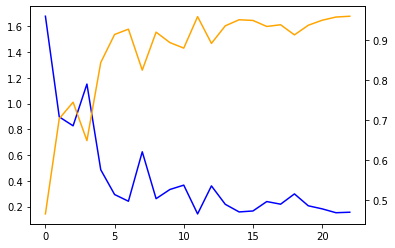

In [11]:
fig = plt.figure()
ax_loss = fig.add_subplot(1,1,1)
ax_loss.plot(range(epochs), history['valid_loss'], label='valid_loss', color='blue')
ax_acc = ax_loss.twinx()
ax_acc.plot(range(epochs), history['valid_acc'], label='valid_acc', color='orange')
plt.xlabel('epochs')
plt.show()

In [12]:
accuracy_rate = accuracy.eval(session=sess, feed_dict={
    x_ph: X_test,
    t_ph: T_test
})

print('accuracy_rate =', accuracy_rate)

accuracy_rate = 0.9547
